# BrkRaw Tutorial 1: Getting Started

This notebook mirrors the official Getting Started guidance using the
latest BrkRaw API and the Git LFS example datasets.

## 0. Configure BrkRaw defaults

BrkRaw stores rules/specs/transforms under a config root (default: `~/.brkraw`).
Install the bundled defaults once per environment so metadata parsing works in later steps.

Note: Default rules/specs/transforms will continue to evolve and be standardized as the user base grows; the current version is not complete and contributions are welcome. If they are not installed, there are no baseline rules/specs to reference, so metadata parsing and modality-specific behavior will not work.

In [1]:
from brkraw.core import config as config_core
from brkraw.apps import addon as addon_app
from typing import Dict, Any, cast

config_core.init()
addon_app.install_defaults()

[PosixPath('/Users/shlee/.brkraw/specs/metadata_common.yaml'),
 PosixPath('/Users/shlee/.brkraw/transforms/metadata_transforms.py'),
 PosixPath('/Users/shlee/.brkraw/specs/metadata_func.yaml'),
 PosixPath('/Users/shlee/.brkraw/specs/metadata_anat.yaml'),
 PosixPath('/Users/shlee/.brkraw/specs/mrs.yaml'),
 PosixPath('/Users/shlee/.brkraw/transforms/mrs_transforms.py'),
 PosixPath('/Users/shlee/.brkraw/rules/20-mrs.yaml'),
 PosixPath('/Users/shlee/.brkraw/rules/10-metadata.yaml'),
 PosixPath('/Users/shlee/.brkraw/pruner_specs/deid4share.yaml')]

## 1. Download example data (Git LFS)

The example datasets live in `brkraw-dataset` and are stored with Git LFS.
This cell clones the repo into `data/brkraw-dataset` and pulls the LFS data.


In [2]:
from pathlib import Path
import subprocess
import shutil

DATA_DIR = Path("data")
DATASET_REPO = DATA_DIR / "brkraw-dataset"

def ensure_git_lfs():
    if shutil.which("git") is None:
        raise RuntimeError("git is required but not found in PATH.")
    result = subprocess.run(["git", "lfs", "version"], capture_output=True, text=True)
    if result.returncode != 0:
        raise RuntimeError("git-lfs is required. Install it and rerun this cell.")
    return result.stdout.strip()

print(ensure_git_lfs())
DATA_DIR.mkdir(parents=True, exist_ok=True)

if not DATASET_REPO.exists():
    subprocess.run(["git", "clone", "https://github.com/BrkRaw/brkraw-dataset", str(DATASET_REPO)], check=True)

subprocess.run(["git", "-C", str(DATASET_REPO), "lfs", "pull"], check=True)
print("Dataset repo ready:", DATASET_REPO)

git-lfs/3.7.1 (GitHub; darwin arm64; go 1.25.3)
Dataset repo ready: data/brkraw-dataset


## 2. Load a dataset

We will use the Paravision 6.0.1 example archive.


In [3]:
from pathlib import Path
import brkraw as brk

dataset_zip = DATASET_REPO / "PV6.0.1" / "UNC_PV6.0.1_FLASH_TurboRARE_EPI.zip"
dataset_zip.exists()

True

In [4]:
loader = brk.load(str(dataset_zip))
loader.avail

{3: Scan(id=3 rel='/3' Method='<Bruker:FLASH>'),
 6: Scan(id=6 rel='/6' Method='<Bruker:RARE>'),
 7: Scan(id=7 rel='/7' Method='<Bruker:FLASH>'),
 10: Scan(id=10 rel='/10' Method='<Bruker:FieldMap>'),
 11: Scan(id=11 rel='/11' Method='<Bruker:EPI>')}

## 3. Inspect study and scan metadata

BrkRaw can return info tables as dictionaries for programmatic access.


In [5]:
info = loader.info(scope="full", as_dict=True)
info["Study"]

{'Software': 'Paravision v6.0.1',
 'Opperator': 'nmrsu',
 'Date': datetime.datetime(2000, 1, 1, 0, 0),
 'ID': '1',
 'Number': '1',
 'InstanceUID': '1.2.3.4.5'}

## 4. Read data arrays and affines

Pick the first available scan/reco pair.


In [6]:
import numpy as np

scan_id = sorted(loader.avail.keys())[0]
reco_id = sorted(loader.avail[scan_id].avail.keys())[0]
scan_id, reco_id

(3, 1)

Note: For multiple slice-pack images (e.g., localizers), the get methods return a tuple. For this tutorial, `first_pack` simply selects the first entry so we can work with a single image and its affine.

In [7]:
def first_pack(value):
    return value[0] if isinstance(value, tuple) else value

data = first_pack(loader.get_dataobj(scan_id, reco_id=reco_id))
affine = first_pack(loader.get_affine(scan_id, reco_id=reco_id))
data.shape, affine  # type: ignore

((256, 256, 1),
 array([[-0.117188,  0.      , -0.      , 15.      ],
        [ 0.      ,  0.      , -4.      , -0.      ],
        [-0.      , -0.117188, -0.      , 10.      ],
        [ 0.      ,  0.      ,  0.      ,  1.      ]]))

## 5. Quick visualization

Plot a center slice to verify the data load.


Note: This tutorial does not cover orientation, so we use a simple x/y plot with a lower-left origin for visualization. For orientation details, see `01_orientation_unwrap_vs_pose.ipynb`.

(np.float64(-0.5), np.float64(255.5), np.float64(-0.5), np.float64(255.5))

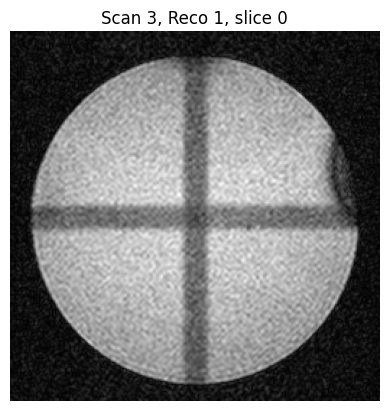

In [8]:
import matplotlib.pyplot as plt

slice_idx = data.shape[2] // 2 # type: ignore
plt.imshow(np.rot90(data[:, :, slice_idx]),  # type: ignore
           cmap="gray", origin="lower")
plt.title(f"Scan {scan_id}, Reco {reco_id}, slice {slice_idx}")
plt.axis("off")

## 6. Convert to NIfTI

Convert the selected scan to NIfTI and write it to `outputs/`.


In [9]:
from pathlib import Path

out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

nifti = loader.convert(scan_id, reco_id=reco_id, format="nifti")
if isinstance(nifti, tuple):
    for idx, img in enumerate(nifti, start=1):
        img.to_filename(out_dir / f"scan{scan_id}_reco{reco_id}_slpack{idx}.nii.gz")
else:
    nifti.to_filename(out_dir / f"scan{scan_id}_reco{reco_id}.nii.gz")

## 7. Metadata and parameter search

In this section, we introduce how brkraw searches metadata parameters per scan and how the rules/specs for metadata parsing are designed (for custom users).


In [10]:
from brkraw.apps import addon
from brkraw.specs import remapper
from pprint import pprint

### Parameter search
brkraw is designed to allow parameter search at every level of the data object hierarchy, and it is case-insensitive by default.


In [11]:
loader.search_params?

Signature:
loader.search_params(
    key: 'str',
    *,
    file: 'Optional[Union[str, List[str]]]' = None,
    scan_id: 'Optional[int]' = None,
    reco_id: 'Optional[int]' = None,
)
Docstring:
Search parameter files for keys on study/scan/reco objects.

Args:
    key: Parameter key to search for.
    file: Filename or list of filenames to search.
    scan_id: Scan id (required when searching from Study).
    reco_id: Reco id (optional; flattens results for that reco).

Returns:
    Mapping of filename to found values, or None if no hits.
File:      ~/Projects/BrkRaw/brkraw/src/brkraw/apps/loader/core.py
Type:      method

In [12]:
print("Loader level:")
pprint(loader.search_params("dim", scan_id=scan_id))

print("\nScan level:")
scan = loader.get_scan(scan_id=scan_id)
pprint(scan.search_params("dim"))

print("\nReco level:")
reco = scan.get_reco(reco_id=reco_id)
pprint(reco.search_params("dim"))

Loader level:
{'acqp': {'ACQ_dim': 2,
          'ACQ_dim_desc': array(['Spatial', 'Spatial'], dtype='<U7'),
          'GS_dim': 1},
 'method': {'PVM_SpatDimEnum': '<2D>'},
 'reco': {'reco_1': {'RecoDim': 2, 'RecoSortDim': 2}},
 'visu_pars': {'reco_1': {'VisuCoreDim': 2,
                          'VisuCoreDimDesc': array(['spatial', 'spatial'], dtype='<U7'),
                          'VisuFGOrderDescDim': 1},
               'scan': {'VisuCoreDim': 2,
                        'VisuCoreDimDesc': array(['spatial', 'spatial'], dtype='<U7'),
                        'VisuFGOrderDescDim': 1}}}

Scan level:
{'acqp': {'ACQ_dim': 2,
          'ACQ_dim_desc': array(['Spatial', 'Spatial'], dtype='<U7'),
          'GS_dim': 1},
 'method': {'PVM_SpatDimEnum': '<2D>'},
 'reco': {'reco_1': {'RecoDim': 2, 'RecoSortDim': 2}},
 'visu_pars': {'reco_1': {'VisuCoreDim': 2,
                          'VisuCoreDimDesc': array(['spatial', 'spatial'], dtype='<U7'),
                          'VisuFGOrderDescDim': 1

The following example shows how the scan-specific workflow operates using rules.
Rules exist per category. The currently provided categories are `info_spec`, `metadata_spec`, and `converter_hook`, and more can be added if needed.

The code below shows which rules are installed by default and the structure of one of them.


In [13]:
from brkraw.specs.rules import load_rules

rules = load_rules()

first_rule = rules["metadata_spec"][0] if rules["metadata_spec"] else None
pprint(first_rule)

{'__category__': 'metadata_spec',
 '__spec_path__': PosixPath('/Users/shlee/.brkraw/specs/metadata_common.yaml'),
 '__transforms__': {'Optional': typing.Optional,
                    'as_list': <function as_list at 0x122908dc0>,
                    'first_seconds': <function first_seconds at 0x122908ca0>,
                    'freq_to_field': <function freq_to_field at 0x122909240>,
                    'normalize_method': <function normalize_method at 0x122909a20>,
                    'pick_value': <function pick_value at 0x1229085e0>,
                    'strip_jcamp_string': <function strip_jcamp_string at 0x1229088b0>,
                    'to_seconds': <function to_seconds at 0x122908820>,
                    'volume_timing': <function volume_timing at 0x122908280>},
 'description': 'Default metadata mapping for Bruker scans.',
 'name': 'metadata-common',
 'use': 'specs/metadata_common.yaml'}


Now, prepare a scan object and check which rule is selected when this scan constructs its metadata.


In [14]:
from brkraw.specs.rules import load_rules, select_rule_use, rule_matches
from brkraw.core import config 

rules = load_rules()
base = config.resolve_root(None)

scan = loader.get_scan(scan_id=scan_id)

selected_use = select_rule_use(scan, rules["metadata_spec"], base=base)

selected_rule = None
for rule in rules["metadata_spec"]:
    if rule_matches(scan, rule, base=base):
        selected_rule = rule
        break

print("selected_use:", selected_use)
print("selected_rule:")
pprint(selected_rule)


selected_use: /Users/shlee/.brkraw/specs/metadata_anat.yaml
selected_rule:
{'__category__': 'metadata_spec',
 '__spec_path__': PosixPath('/Users/shlee/.brkraw/specs/metadata_common.yaml'),
 '__transforms__': {'Optional': typing.Optional,
                    'as_list': <function as_list at 0x12290a0e0>,
                    'first_seconds': <function first_seconds at 0x122909fc0>,
                    'freq_to_field': <function freq_to_field at 0x12290a050>,
                    'normalize_method': <function normalize_method at 0x12290a170>,
                    'pick_value': <function pick_value at 0x12290a200>,
                    'strip_jcamp_string': <function strip_jcamp_string at 0x122909ea0>,
                    'to_seconds': <function to_seconds at 0x122909f30>,
                    'volume_timing': <function volume_timing at 0x12290a290>},
 'description': 'Default metadata mapping for Bruker scans.',
 'name': 'metadata-common',
 'use': 'specs/metadata_common.yaml'}


Next, let's inspect what parameter set the selected metadata spec is designed to generate.


In [15]:
if selected_rule is not None:
    metadata_spec_path = addon.resolve_spec_reference(selected_rule['use'])
    anat_metadata_spec, transform = remapper.load_spec(metadata_spec_path)
    pprint(anat_metadata_spec)
else:
    raise FileNotFoundError("Rule not found. Install default rule / spec set first.")

{'CoilCombinationMethod': {'inputs': {'value': {'const': None}},
                           'transform': 'pick_value'},
 'DeviceSerialNumber': {'sources': [{'file': 'visu_pars',
                                     'key': 'VisuSystemOrderNumber'}]},
 'GradientSetType': {'sources': [{'file': 'acqp', 'key': 'ACQ_status'}],
                     'transform': 'strip_jcamp_string'},
 'InstitutionAddress': {'inputs': {'value': {'const': None}},
                        'transform': 'pick_value'},
 'InstitutionName': {'sources': [{'file': 'visu_pars',
                                  'key': 'VisuInstitution'}],
                     'transform': 'strip_jcamp_string'},
 'InstitutionalDepartmentName': {'inputs': {'value': {'const': None}},
                                 'transform': 'pick_value'},
 'MagneticFieldStrength': {'inputs': {'freq': {'sources': [{'file': 'visu_pars',
                                                            'key': 'VisuAcqImagingFrequency'}]}},
                     

The spec above is already installed, and the rule applies that `metadata_spec` to the scan we selected. Now let's look at the result; everything is applied automatically under the hood.


In [ ]:
meta = scan.get_metadata(reco_id=1)
if meta:
    pprint(meta)

{'CoilCombinationMethod': None,
 'DeviceSerialNumber': '<>',
 'EchoTime': [0.003368],
 'EffectiveEchoSpacing': None,
 'FlipAngle': 30,
 'GradientSetType': 'Unknown',
 'InstitutionAddress': None,
 'InstitutionName': '',
 'InstitutionalDepartmentName': None,
 'InversionTime': None,
 'MagneticFieldStrength': 9.403046781392733,
 'Manufacturer': 'Bruker BioSpin MRI GmbH',
 'ManufacturersModelName': 'Biospec 94/30',
 'MultibandAccelerationFactor': None,
 'NonlinearGradientCorrection': 'RectilinearTraversal',
 'PhaseEncodingDirection': None,
 'PulseSequenceDetails': '1_Localizer_GOP (E3)',
 'PulseSequenceType': 'Unknown',
 'ReceiveCoilActiveElements': 'Unknown',
 'ReceiveCoilName': 'Unknown',
 'RepetitionTime': [0.1],
 'ScanningSequence': 'Bruker:FLASH',
 'SequenceName': '1_Localizer_GOP',
 'SequenceVariant': 'GradientEcho',
 'SoftwareVersions': '6.0.1',
 'StationName': 'Biospec 94/30',
 'TotalReadoutTime': None,
 'TransmitCoilName': 'Unknown'}
